In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons
from sbident import SBIdent

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from tess_asteroid_ml.utils import *
from tess_asteroid_ml.make_TESS_asteroid_db import *
from ipywidgets import *

In [38]:
sector = 13
camera = 2
ccd = 1
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

path = "/Volumes/ADAP-Kepler/Work/BAERI/data/tess/ffi"
cutout_size = 64

In [39]:
provider = "mast"

# get FFI image
ffi_file = get_FFI_name(
    sector=sector, camera=camera, ccd=ccd, provider=provider, correct=False
)
ffi_file

['https://archive.stsci.edu/missions/tess/ffi/s0013/2019/184/2-1/tess2019184035930-s0013-2-1-0146-s_ffic.fits']

In [40]:
# get FFI data to build ra/dec coordinates for later query
ffi_header, f2d, col_2d, row_2d, ra_2d, dec_2d = get_data_from_files(
    ffi_file, provider=provider
)
ffi_header = ffi_header[0]
f2d = f2d[0]
col_2d = col_2d
row_2d = row_2d
ra_2d = ra_2d[0]
dec_2d = dec_2d[0]

obs_time = Time([ffi_header["DATE-OBS"], ffi_header["DATE-END"]], format="isot")

Set MJD-END to 58667.191018 from DATE-END'. [astropy.wcs.wcs]


In [41]:
ffi_coord = SkyCoord(ra_2d*u.deg, dec_2d*u.deg, frame='icrs', obstime=obs_time.mean().isot)

In [42]:
ccd = 0
scc_str = f"s{sector:04}-{camera}-{ccd}"

In [43]:
jpl_sbi_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/jpl_small_bodies_tess_{scc_str}_catalog.csv"

if os.path.isfile(jpl_sbi_file):
    print(f"Loading from CSV file {jpl_sbi_file}...")
    jpl_sb = pd.read_csv(jpl_sbi_file, index_col=0)

jpl_sb_bright = jpl_sb.query("V_mag <= 21")
jpl_sb_bright

Loading from CSV file /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0013-2-0_catalog.csv...


,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,605 Juvisia (A906 QJ),18:46:34.06,-50:00:22.7,-10000.0,50000.0,52000.0,14.4,-35.31,0.260,281.641917,-50.006306,14.4,605 Juvisia,A906 QJ
1,1192 Prisma (1931 FE),17:49:15.75,-59:45:41.5,-40000.0,10000.0,42000.0,17.1,-37.90,7.847,267.315625,-59.761528,17.1,1192 Prisma,1931 FE
2,1317 Silvretta (1935 RC),17:33:41.67,-51:03:53.7,-40000.0,40000.0,69000.0,15.6,-30.03,3.384,263.423625,-51.064917,15.6,1317 Silvretta,1935 RC
3,1508 Kemi (1938 UP),16:44:03.66,-58:31:53.6,-60000.0,20000.0,70000.0,18.1,-27.81,10.320,251.015250,-58.531556,18.1,1508 Kemi,1938 UP
4,1919 Clemence (1971 SA),16:44:28.73,-57:03:48.9,-60000.0,20000.0,73000.0,16.6,-37.20,20.610,251.119708,-57.063583,16.6,1919 Clemence,1971 SA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347,(2023 FK23),20:20:13.62,-69:42:12.6,20000.0,-20000.0,30000.0,20.7,-21.20,-35.360,305.056750,-69.703500,20.7,NaN,2023 FK23
3348,(2023 FK26),15:44:08.68,-69:17:02.1,-90000.0,-20000.0,79000.0,19.9,-38.20,-7.610,236.036167,-69.283917,19.9,NaN,2023 FK26
3378,(2023 QK85),15:07:40.63,-59:25:38.1,-100000.0,10000.0,110000.0,21.0,-12.36,15.330,226.919292,-59.427250,21.0,NaN,2023 QK85
3391,186P/Garradd,16:20:21.34,-55:06:36.6,-70000.0,30000.0,87000.0,18.9N,-15.78,15.010,245.088917,-55.110167,18.9,186P/Garradd,186P/Garradd


In [45]:
sb_ephems_lowres = {}

for k, row in jpl_sb_bright.iterrows():
    
    feath_file = f"{os.path.dirname(PACKAGEDIR)}/data/jpl/tracks/sector{sector:04}/tess-ffi_s{sector:04}-0-0_{row['id'].replace(' ', '-')}_hires.feather"
    if os.path.isfile(feath_file):
        sb_ephems_lowres[k] = pd.read_feather(feath_file)
len(sb_ephems_lowres)

141

In [52]:
ccd = 4

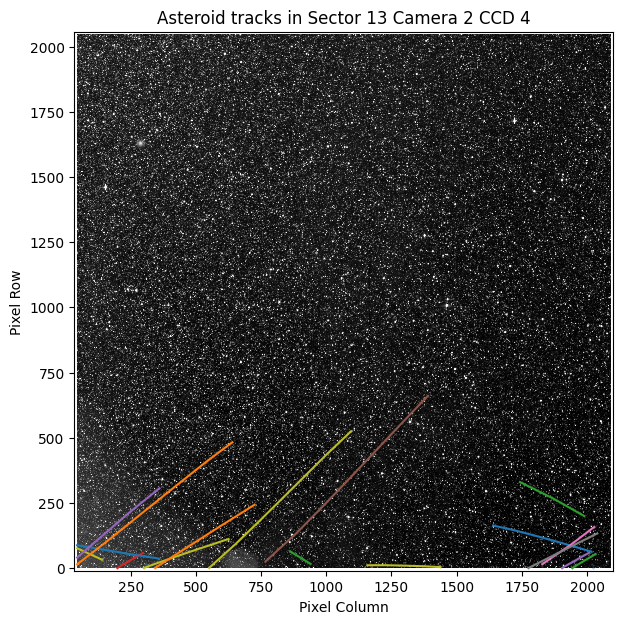

In [53]:
vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 1, 50, 95, 99.8])
cnorm = colors.SymLogNorm(linthresh=mid, vmin=lo, vmax=vhi, base=10)
cnorm = colors.LogNorm(vmin=lo, vmax=vhi)

plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [ ]:
vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 1, 50, 95, 99.8])
cnorm = colors.SymLogNorm(linthresh=mid, vmin=lo, vmax=vhi, base=10)
cnorm = colors.LogNorm(vmin=lo, vmax=vhi)

plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column[::100], val.row[::100], ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [31]:
sb_ephems_lowres[0]

,time,sector,camera,ccd,column,row,pixels_per_hour,ra,dec,vmag,sun_distance,obs_distance,phase_angle
0,2.458411e+06,4,1,4,155.360952,606.735635,1.790637,38.100323,5.161421,10.612587,2.533602,1.557375,5.821726
1,2.458411e+06,4,1,4,156.259098,606.615989,1.793747,38.095163,5.160414,10.612057,2.533548,1.557251,5.813777
2,2.458411e+06,4,1,4,157.158311,606.494889,1.796762,38.089995,5.159412,10.611521,2.533495,1.557128,5.805826
3,2.458411e+06,4,1,4,158.058571,606.372355,1.799684,38.084819,5.158416,10.610978,2.533442,1.557005,5.797873
4,2.458411e+06,4,1,4,158.959856,606.248404,1.802515,38.079635,5.157426,10.610429,2.533389,1.556882,5.789919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2.458437e+06,4,1,4,1258.791930,315.298506,1.375049,31.635577,4.647965,10.629053,2.467408,1.522068,8.552542
1056,2.458437e+06,4,1,4,1259.485198,315.078776,1.372831,31.631571,4.647805,10.629237,2.467355,1.522108,8.560928
1057,2.458437e+06,4,1,4,1260.177423,314.860238,1.370622,31.627572,4.647640,10.629412,2.467301,1.522147,8.569311
1058,2.458437e+06,4,1,4,1260.868603,314.642902,1.368420,31.623581,4.647470,10.629577,2.467248,1.522187,8.577694


In [45]:
track_lengh = []
vmag = []
rate = []

for chip in range(1, 5):
    for k, val in sb_ephems_lowres.items():
        val = val.query(f"camera == {camera} and ccd == {chip}")
        if len(val) == 0:
            continue
        hypot = np.hypot(val.column.values[-1] - val.column.values[0], 
                         val.row.values[-1] - val.row.values[0])
        track_lengh.append(hypot)
        vmag.append(val.vmag.mean())
        rate.append(val.pixels_per_hour.mean())
track_lengh = np.array(track_lengh)
vmag = np.array(vmag)
rate = np.array(rate)

In [53]:
rate.min()

1.1428147802791637

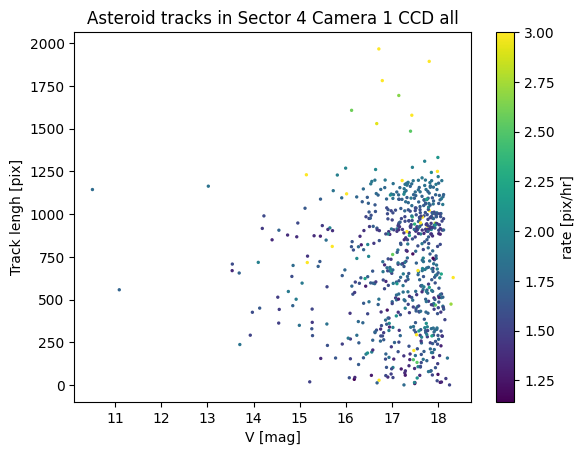

In [54]:
bar = plt.scatter(vmag, track_lengh, c=rate, vmin=rate.min(), vmax=3, s=2, marker="o")
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD all")
plt.colorbar(bar, label="rate [pix/hr]")
plt.xlabel("V [mag]")
plt.ylabel("Track lengh [pix]")
plt.show()